In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':20})
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from scipy.sparse.linalg import svds

from surprise import (SVD
                      , SVDpp
                      , NMF
                      , NormalPredictor
                      , BaselineOnly)
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection.split import train_test_split
from surprise.model_selection.validation import cross_validate
from surprise import accuracy

from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from matplotlib import rcParams, cm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.models import (load_data
                        , data_summary
                        , combine_tables
                        , collab_mat
                        , svd_mat
                        , svd_model
                        , surprise_bench
                        , top_biz_pred
                        , NMF_Mat
                        , NN_Model
                        , NN_Results_df
                        , con_bas_biz_rec
                       )

### Load Data

In [5]:
biz_df, rev_df, ckin_df, pho_df, tip_df, user_df = load_data()

In [6]:
data_summary(biz_df
             , rev_df
             , ckin_df
             , pho_df
             , tip_df
             , user_df)

name,rows,colums
business,192609,14
review,6685900,9
checkin,161950,2
photo,200000,4
tip,1223094,5
user,1637138,22


In [7]:
user_rev_biz = combine_tables(user_df
                              , rev_df
                              , biz_df)

In [8]:
user_rev_biz.city.value_counts()[0:5]

Las Vegas     1757375
Phoenix        645716
Toronto        434349
Scottsdale     329826
Charlotte      273989
Name: city, dtype: int64

In [10]:
user_rev_biz_scott = user_rev_biz.loc[user_rev_biz.city == 'Scottsdale']
user_rev_biz_scott.shape

(329826, 36)

In [11]:
len(user_rev_biz_scott.user_id.unique())

140940

In [12]:
len(user_rev_biz_scott.business_id.unique())

7081

In [13]:
average_user_stars_given = pd.DataFrame(user_rev_biz_scott.average_stars.value_counts())

In [14]:
user_rev_biz_scott.average_stars.mean()

3.849698052912747

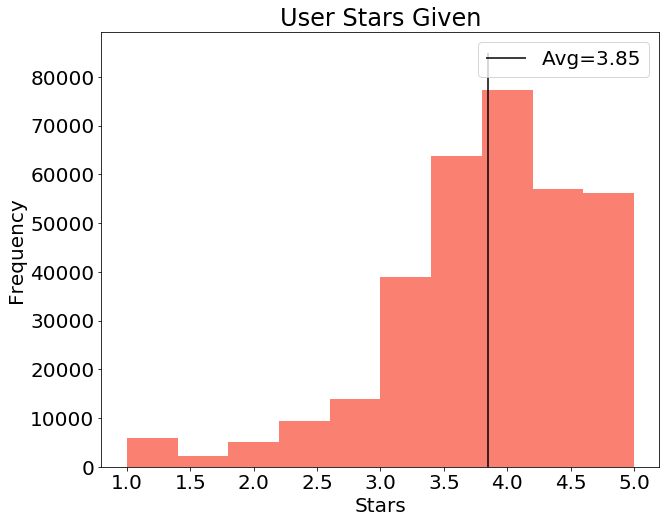

In [16]:
plt.figure(figsize=(10,8))

plt.hist(user_rev_biz_scott.average_stars, color='salmon')
plt.vlines(3.85, 0, 85000, label = 'Avg=3.85')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('User Stars Given')
plt.legend();
plt.savefig('png/user_stars_given.png')

In [17]:
biz_stars_df = pd.DataFrame(user_rev_biz_scott.biz_star.value_counts().sort_index())

In [18]:
user_rev_biz_scott.biz_star.mean()

3.9298751462892554

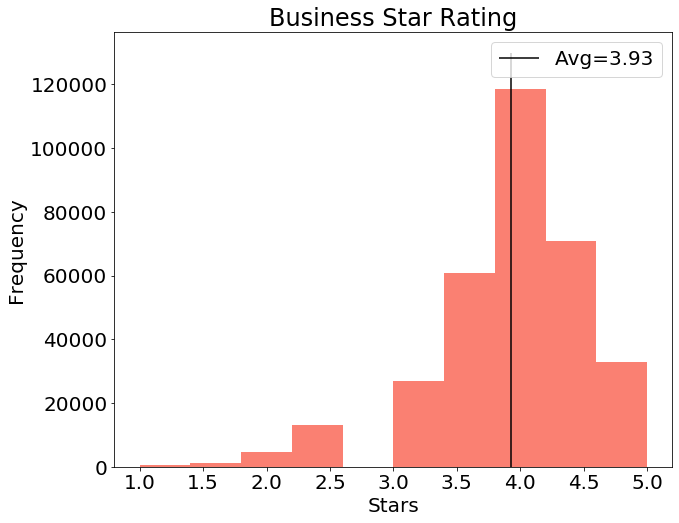

In [20]:
plt.figure(figsize=(10,8))
plt.hist(user_rev_biz_scott.biz_star, color='salmon')
plt.vlines(3.93, 0, 130000, label='Avg=3.93')
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Business Star Rating')
plt.legend();
plt.savefig('png/biz_stars_rating.png')

In [21]:
user_rev_biz_scott.biz_review_count.median()

191.0

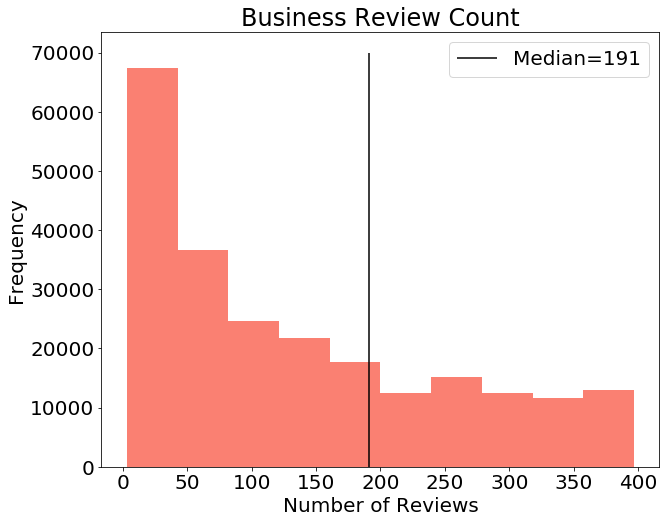

In [22]:
plt.figure(figsize=(10,8))
plt.hist(user_rev_biz_scott.biz_review_count.loc[user_rev_biz_scott.biz_review_count < 400], color='salmon')
plt.vlines(191, 0, 70000, label='Median=191')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('Business Review Count')
plt.legend();
plt.savefig('png/biz_rev_count.png')

In [23]:
user_rev_biz_scott.user_review_count.median()

21.0

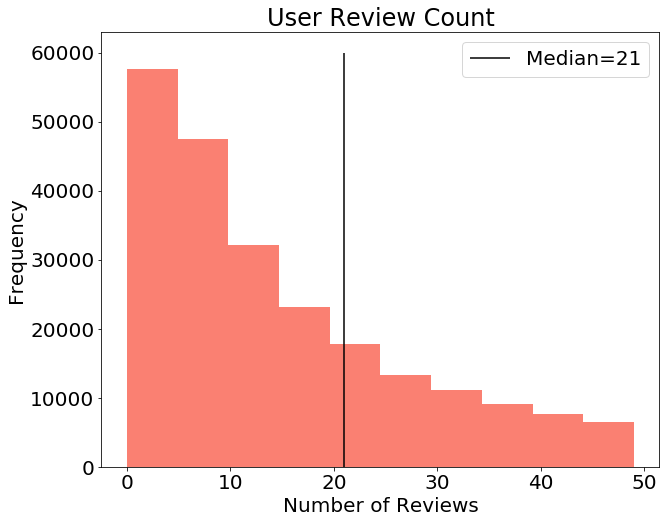

In [24]:
plt.figure(figsize=(10,8))
plt.hist(user_rev_biz_scott.user_review_count.loc[user_rev_biz_scott.user_review_count < 50], color='salmon')
plt.vlines(21, 0, 60000, label='Median=21')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.title('User Review Count')
plt.legend();
plt.savefig('png/user_rev_count.png')

In [34]:
n = 34
cat_short = []
for cat in user_rev_biz_scott.categories.value_counts()[0:n].index:
    cat_short.append(cat[:9])
cat_short = np.array(cat_short)
cat_short

array(['Mexican, ', 'Restauran', 'Nightlife', 'Latin Ame', 'American ',
       'Cocktail ', 'American ', 'Nightlife', 'Mexican, ', 'Sandwiche',
       'Restauran', 'Food, Mex', 'Brazilian', 'Restauran', 'Vegetaria',
       'Pizza, Re', 'Coffee & ', 'Nightlife', 'American ', 'American ',
       'Farmers M', 'Salad, Bu', 'Restauran', 'Food, Res', 'Event Pla',
       'American ', 'Steakhous', 'Sandwiche', 'Breakfast', 'Sandwiche',
       'Persian/I', 'American ', 'Restauran', 'Cafes, Am'], dtype='<U9')

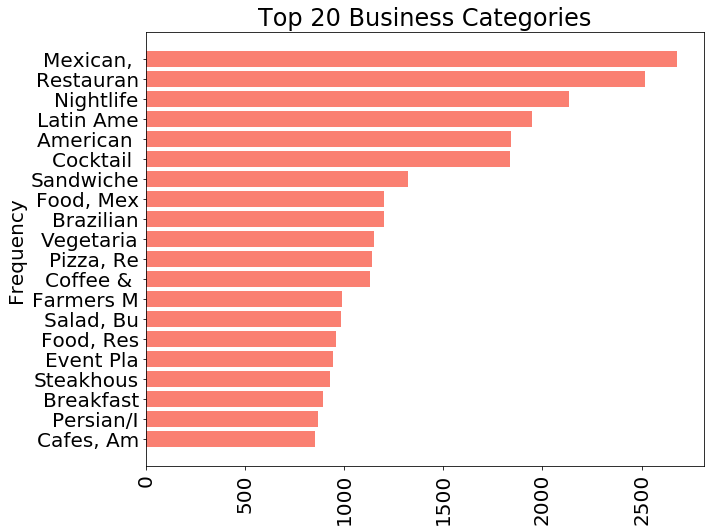

In [37]:
plt.figure(figsize=(10,8))

plt.barh(cat_short
       , user_rev_biz_scott.categories.value_counts()[0:n].values, color='salmon')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.gca().invert_yaxis()
plt.title('Top 20 Business Categories');
plt.savefig('png/top_20_biz_cat.png')

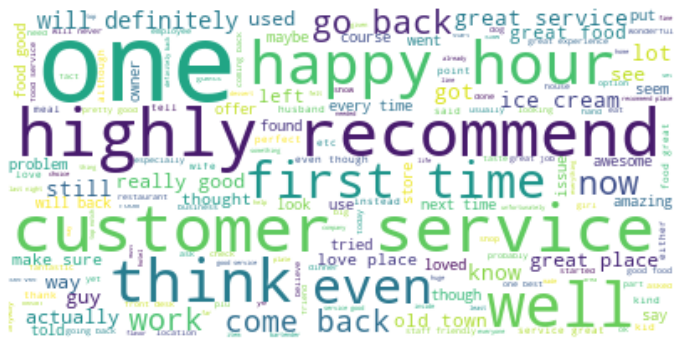

<Figure size 432x288 with 0 Axes>

In [114]:
all_rev_words_scott = ' '.join(user_rev_biz_scott.rev_text.str.lower())

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=200).generate(all_rev_words_scott)

# Display the wordcloud image:
plt.figure(figsize=[12,9])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show(); 
# plt.savefig('png/wordcloud_reviews.png');

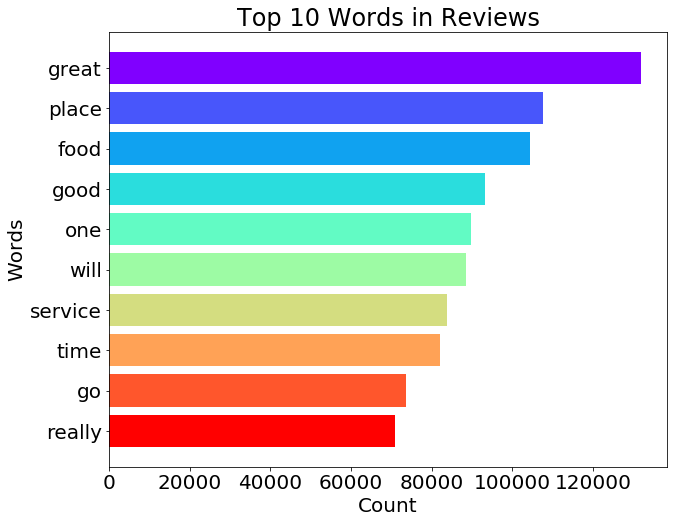

In [51]:
stopwords = STOPWORDS

filtered_words = [word for word in all_rev_words_scott.split() if word not in stopwords]
counted_words = Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=[10, 8])

plt.title('Top 10 Words in Reviews')
plt.xlabel('Count')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.barh(words, counts, color=colors);
plt.savefig('png/top_10_words_rev.png')

In [42]:
biz_id_scott = user_rev_biz_scott.business_id.unique()

In [43]:
biz_id_scott

array(['lV3qjLJF_5QujITWHZ64gg', 'p-8AMN9Q0qwym-3Pdle20Q',
       '-LRlx2j9_LB3evsRRcC9MA', ..., '5HPBIG3BVMIfy4_-D9zPIQ',
       'k-qjgxB45hV0627P6KRYJQ', 'a4PI8XlT_nXrH93vAo28UQ'], dtype=object)

In [44]:
len(biz_id_scott)

7081

In [45]:
tip_df.columns

Index(['user_id', 'business_id', 'text', 'date', 'compliment_count'], dtype='object')

In [46]:
tip_df.shape

(1223094, 5)

In [47]:
tip_df_scott = tip_df[tip_df.business_id.isin(biz_id_scott)]

In [48]:
tip_df_scott.shape

(51387, 5)

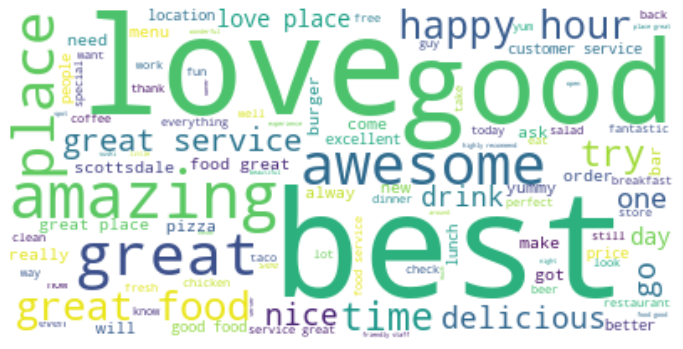

<Figure size 432x288 with 0 Axes>

In [115]:
all_tip_words_scott = ' '.join(tip_df_scott.text.str.lower())

# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=100).generate(all_tip_words_scott)

# Display the wordcloud image:
plt.figure(figsize=[12,9])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");
# plt.savefig('png/wordcloud_tips.png');

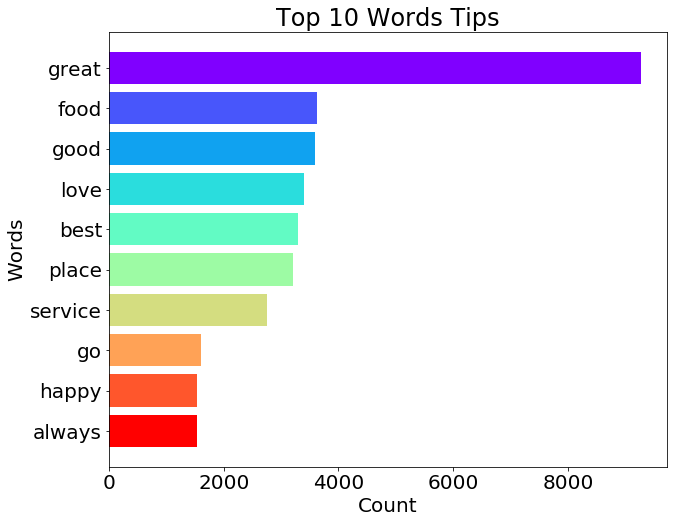

In [52]:
stopwords = STOPWORDS
stopwords.add('&')


f word not in stopwords]
counted_words = Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(10):
    words.append(letter)
    counts.append(count)
    
colors = cm.rainbow(np.linspace(0, 1, 10))
plt.figure(figsize=[10, 8])

plt.title('Top 10 Words Tips')
plt.xlabel('Count')
plt.ylabel('Words')
plt.gca().invert_yaxis()
plt.barh(words, counts, color=colors);
plt.savefig('png/top_10_words_tip.png')

In [53]:
ckin_df.shape

(161950, 2)

In [54]:
ckin_df_scott = ckin_df[ckin_df.business_id.isin(biz_id_scott)]

In [55]:
ckin_df_scott.shape

(5638, 2)

In [56]:
ckin_df_scott.columns

Index(['business_id', 'date'], dtype='object')

In [57]:
ckin_df_scott['date'].iloc[0]

'2010-03-23 05:49:25, 2010-08-27 05:38:45, 2010-09-05 23:37:14, 2010-09-10 02:13:41, 2010-10-26 19:01:51, 2010-12-10 21:23:20, 2010-12-23 21:47:12, 2011-01-04 20:23:02, 2011-01-16 21:18:05, 2011-01-22 06:05:02, 2011-01-22 20:24:46, 2011-01-22 21:42:04, 2011-02-02 16:31:12, 2011-02-03 18:46:48, 2011-02-19 04:02:34, 2011-03-18 18:51:57, 2011-04-16 02:49:44, 2011-04-16 02:50:57, 2011-04-22 05:38:01, 2011-04-27 14:45:58, 2011-05-19 14:40:43, 2011-05-20 00:01:04, 2011-05-26 20:01:58, 2011-05-31 14:43:41, 2011-06-01 14:46:34, 2011-06-03 03:44:22, 2011-06-05 15:50:45, 2011-06-05 21:58:51, 2011-06-10 14:46:09, 2011-06-10 18:49:33, 2011-06-11 13:43:32, 2011-06-11 20:46:51, 2011-06-12 00:47:30, 2011-06-12 22:48:05, 2011-06-13 02:59:13, 2011-06-13 14:16:25, 2011-06-13 23:34:56, 2011-06-15 00:03:00, 2011-06-15 23:47:11, 2011-06-16 04:01:12, 2011-06-16 14:47:48, 2011-06-17 00:05:25, 2011-06-17 15:26:03, 2011-06-20 17:53:19, 2011-06-22 18:46:58, 2011-06-22 18:49:22, 2011-07-01 05:01:10, 2011-07-01 0

In [58]:
ckin_df_scott.head()

,business_id,date
45,-01XupAWZEXbdNbxNg5mEg,"2010-03-23 05:49:25, 2010-08-27 05:38:45, 2010..."
101,-1BPe8UjF2_l3nVk-DFUjA,"2015-12-03 18:44:00, 2016-03-17 18:19:21, 2016..."
151,-2TKoFglMQvSmHSNWf6S8Q,"2012-08-14 01:38:56, 2012-09-18 23:27:48, 2012..."
183,-37_L44VjFw1U4tBfBDHRw,"2015-01-21 18:10:30, 2015-02-14 01:31:49, 2015..."
216,-4-2NZvqC68eOCiwmCQTiQ,"2018-05-16 19:50:42, 2018-09-08 00:44:43"


In [65]:
ckin_df_scott['checkins'] = ckin_df_scott.date.str.split(', ').apply(len)

In [68]:
ckin_df_scott.head()

,business_id,date,checkins
45,-01XupAWZEXbdNbxNg5mEg,"2010-03-23 05:49:25, 2010-08-27 05:38:45, 2010...",307
101,-1BPe8UjF2_l3nVk-DFUjA,"2015-12-03 18:44:00, 2016-03-17 18:19:21, 2016...",3
151,-2TKoFglMQvSmHSNWf6S8Q,"2012-08-14 01:38:56, 2012-09-18 23:27:48, 2012...",6
183,-37_L44VjFw1U4tBfBDHRw,"2015-01-21 18:10:30, 2015-02-14 01:31:49, 2015...",8
216,-4-2NZvqC68eOCiwmCQTiQ,"2018-05-16 19:50:42, 2018-09-08 00:44:43",2


In [69]:
ckin_df_scott.checkins.value_counts()

1       572
2       365
3       284
4       247
5       153
       ... 
330       1
326       1
298       1
286       1
1999      1
Name: checkins, Length: 891, dtype: int64

In [70]:
ckin_df_scott.checkins.median()

21.0

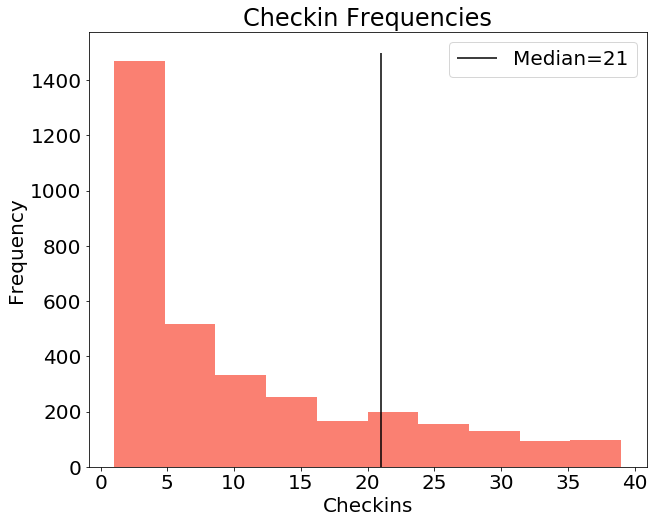

In [72]:
plt.figure(figsize=[10,8])
plt.hist(ckin_df_scott.checkins.loc[ckin_df_scott.checkins < 40], color = 'salmon')
plt.vlines(21, 0, 1500, label='Median=21')
plt.xlabel('Checkins')
plt.ylabel('Frequency')
plt.title('Checkin Frequencies')
plt.legend();
plt.savefig('png/checkin_frequencies.png')

### SVD

In [73]:
user_biz_collab_mat = collab_mat('Scottsdale'
                                 , user_rev_biz)

In [74]:
sigma, user_biz_predictions = svd_mat(user_biz_collab_mat, k=40)

### SVD Predictions

In [88]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = user_biz_predictions
             , n=10)

('Kristin',
 ['True Food Kitchen',
  'Cafe Monarch',
  'The Herb Box',
  'Sweet Republic',
  'Talking Stick Resort',
  'Roka Akor - Scottsdale',
  'Sprinkles Cupcakes',
  "Portillo's Hot Dogs",
  'iPic Theaters',
  'Studio Movie Grill'])

In [76]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:10]

3360        Butters Pancakes & Café
312378                   Wildflower
600627                 Flower Child
624904                 Viet Kitchen
744479                   Wildflower
746301     Original Breakfast House
771054      Andreoli Italian Grocer
838710                 Barrio Queen
1147492        Rocket Burger & Subs
1155989                 Rustic Cafe
Name: biz_name, dtype: object

### NMF

In [85]:
nmf_mat = NMF_Mat(user_biz_collab_mat)

### NMF Predictions

In [89]:
top_biz_pred('--2HUmLkcNHZp0xw6AMBPg'
             , df_all = user_rev_biz
             , df_mat = user_biz_collab_mat
             , df_pred = nmf_mat
             , n=10)

('Kristin',
 ['True Food Kitchen',
  'North Italia',
  "Portillo's Hot Dogs",
  "Mastro's Ocean Club",
  'Sweet Republic',
  'AZ88',
  "Grimaldi's Pizzeria",
  'Studio Movie Grill',
  'Four Peaks Grill & Tap',
  'Cien Agaves Tacos & Tequila - Old Town Scottsdale'])

In [87]:
user_rev_biz['biz_name'].loc[user_rev_biz.user_id == '--2HUmLkcNHZp0xw6AMBPg'][0:10]

3360        Butters Pancakes & Café
312378                   Wildflower
600627                 Flower Child
624904                 Viet Kitchen
744479                   Wildflower
746301     Original Breakfast House
771054      Andreoli Italian Grocer
838710                 Barrio Queen
1147492        Rocket Burger & Subs
1155989                 Rustic Cafe
Name: biz_name, dtype: object

### Validation

In [77]:
data, svd_acc, svd_cv = svd_model(df = user_rev_biz)

RMSE: 0.7007


In [78]:
svd_acc

0.7006788795078541

In [79]:
svd_cv

array([0.70144797, 0.70032458, 0.69738021, 0.6949949 , 0.70044193])

In [83]:
NMF_results = cross_validate(NMF(), data, cv = 5)

In [84]:
NMF_results['test_rmse']

array([0.63398005, 0.64201131, 0.64625629, 0.64012164, 0.63778169])

In [80]:
bench_df = surprise_bench(df=user_rev_biz)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [81]:
bench_df

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
NMF,0.639745,0.404678,20.853446,0.455283
SVDpp,0.681610,0.461567,52.308848,1.613125
SVD,0.699702,0.489766,12.810370,0.635299
BaselineOnly,0.718456,0.509788,1.912540,0.619318
NormalPredictor,1.103164,0.867824,0.546117,0.398780


### Neural Network Predictor (Recommender???)



In [24]:
# Source: https://www.youtube.com/watch?v=4vwNkHFuZBk

In [25]:
from tensorflow.keras.layers import (Input
                                     , Embedding
                                     , Dot
                                     , Flatten
                                    )
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import History
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.callbacks import Callback

import os

In [102]:
user_id_dict, biz_id_dict, X, X_test, model, history = NN_Model(df = user_rev_biz
                                                                , n_factors = 5
                                                                , ep = 16)


Testing loss: 14.479139511562423, acc: 0.0


Testing loss: 11.33973538856641, acc: 0.00014553040091414005


Testing loss: 9.297767035556959, acc: 0.000751907064113766


Testing loss: 8.038695028329967, acc: 0.0012006257893517613


Testing loss: 7.244644333574689, acc: 0.0013704112498089671


Testing loss: 6.732412540159555, acc: 0.001503814128227532


Testing loss: 6.388924376013318, acc: 0.001564451726153493


Testing loss: 6.157052256720192, acc: 0.0016008344246074557


Testing loss: 6.001574964768624, acc: 0.0016250894404947758


Testing loss: 5.897597592927469, acc: 0.0016614720225334167


Testing loss: 5.8244025041493295, acc: 0.0016614720225334167


Testing loss: 5.772865803937378, acc: 0.0016493444563820958


Testing loss: 5.737640681481271, acc: 0.0016614720225334167


Testing loss: 5.710601924790206, acc: 0.0016372170066460967


Testing loss: 5.689910055627986, acc: 0.0016372170066460967


Testing loss: 5.674977072595904, acc: 0.0016493444563820958

Instructions for updating:

In [106]:
test_loss = [14.479139511562423
             , 11.33973538856641
             , 9.297767035556959
             , 8.038695028329967
             , 7.244644333574689
             , 6.732412540159555
             , 6.388924376013318
             , 6.157052256720192
             , 6.001574964768624
             , 5.897597592927469
             , 5.8244025041493295
             , 5.772865803937378
             , 5.737640681481271
             , 5.710601924790206
             , 5.689910055627986
             , 5.674977072595904
            ]

test_accuracy = [0.0
                 , 0.00014553040091414005
                 , 0.000751907064113766
                 , 0.0012006257893517613
                 , 0.0013704112498089671
                 , 0.001503814128227532
                 , 0.001564451726153493
                 , 0.0016008344246074557
                 , 0.0016250894404947758
                 , 0.0016614720225334167
                 , 0.0016614720225334167
                 , 0.0016493444563820958
                 , 0.0016614720225334167
                 , 0.0016372170066460967
                 , 0.0016372170066460967
                 , 0.0016493444563820958
                ]

In [107]:
print(len(test_loss))
print(len(test_accuracy))

16
16


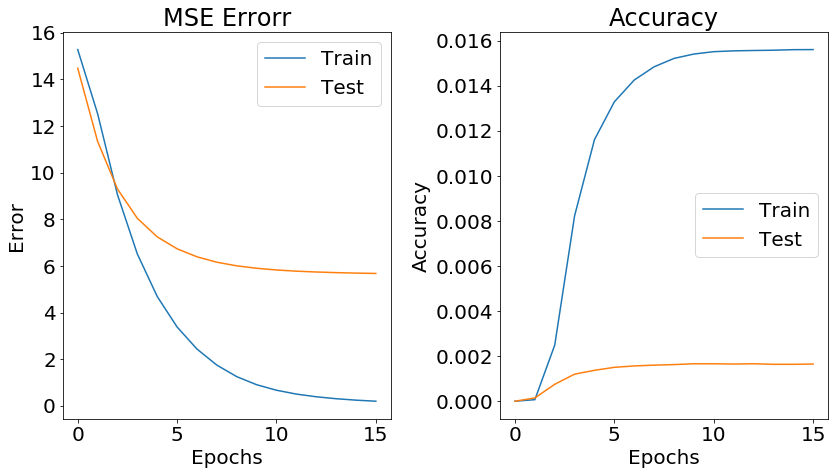

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(12,7), tight_layout=True)
ax[0].plot(history.history['loss'], label='Train')
ax[0].plot(test_loss, label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Error')
ax[0].set_title('MSE Errorr')
ax[0].legend()
    
ax[1].plot(history.history['accuracy'], label='Train')
ax[1].plot(test_accuracy, label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy')
ax[1].legend();
plt.savefig('png/NN_loss_acc.png')

In [388]:
history.history['loss']

[15.326690355382812,
 12.688218907900238,
 9.15206333540052,
 6.59102016322275,
 4.764633427370078,
 3.4511717897860006,
 2.49785679092993,
 1.7983936618526173,
 1.2919597869958965,
 0.9373151135472881,
 0.691722626800223,
 0.5204781883766612,
 0.4011486389245585,
 0.3150621700016195,
 0.250699821632333,
 0.20263138544996379]

In [28]:
NN_Results_df(mod = model
             , xtest = X_test
             , n=15)

,user_name,biz_name,average_stars,Prediction
1600473,Mirco,Merci French Cafe & Patisserie,4.81,5.112354
773319,Scott,McCormick-Stillman Railroad Park,3.62,3.654701
2675092,Ashley,Zoes Kitchen,4.11,3.913429
3141992,Dawn,Scottsdale Nails,4.70,4.576928
2063207,Shaila,Saints & Scissors Salon,4.71,-0.198805
3693030,Shaya,Persian Room,4.06,3.854479
6037906,Marnie,Sir Grout Phoenix,3.75,0.097221
1878741,Chelsea,Houston's Restaurant,4.25,4.256616
4351605,Horace,Nekter Juice Bar,4.75,4.759289
4458509,Stephanie,Blue Adobe Santa Fe Grille,3.75,4.139963


In [90]:
biz_df = user_rev_biz_scott.groupby(['business_id', 'biz_name']).size().reset_index(name="Freq")
biz_df

,business_id,biz_name,Freq
0,-01XupAWZEXbdNbxNg5mEg,18 Degrees,103
1,-1BPe8UjF2_l3nVk-DFUjA,Journey Massage Therapy,8
2,-2TKoFglMQvSmHSNWf6S8Q,U.S. Bank,9
3,-37_L44VjFw1U4tBfBDHRw,Cloud Nine Wellness Spa,6
4,-4-2NZvqC68eOCiwmCQTiQ,Elle Nails,7
...,...,...,...
7076,zyLkrHGJzxCcoCVHjNrXvQ,Able Alterations,3
7077,zyPGYeXF4XKCqNN1pjFWhg,La Locanda Ristorante Italiano,166
7078,zyc1AxImsu2zUm-gN780VQ,Allergy & Environmental Treatment Center,5
7079,zyf4e5p_4X2cNc_WPIiTbg,American Family Dentistry,17


In [93]:
biz_df.drop('Freq', axis=1, inplace=True)

In [94]:
user_df = user_rev_biz_scott.groupby(['user_id', 'user_name']).size().reset_index(name="Freq")
user_df

,user_id,user_name,Freq
0,---PLwSf5gKdIoVnyRHgBA,Rae,1
1,--2HUmLkcNHZp0xw6AMBPg,Kristin,28
2,--3B8LdT1NCD-bPkwS5-5g,Cynthia,1
3,--3WaS23LcIXtxyFULJHTA,Kristie,1
4,--41c9Tl0C9OGewIR7Qyzg,Tamaki,1
...,...,...,...
140935,zzocxUC7iRbX1deMdYHHXQ,Jessica,1
140936,zzp2eum7gHb4YuH1ffavpw,Koko,1
140937,zzpgpo54-_P-4rzzBtOuLQ,Aurélie,1
140938,zzw_26f_S87kQE7_sPBG3A,Trevor,1


In [95]:
user_df.drop('Freq', axis=1, inplace=True)

In [96]:
user_id_list = list(user_df.user_id)

In [97]:
user_id_dict = {y: x for (x, y) in enumerate(user_id_list)}

In [99]:
len(user_id_dict)

140940

In [433]:
predictions = model.predict([np.array([0 for _ in range(7081)])
                             , biz_df.index.values])

In [436]:
len(predictions)

7081

In [404]:
NN_Results_df(mod = model
             , xtest = X_test_one
             , n=15)

KeyError: "['user_name', 'biz_name'] not in index"

### Using Texts to Model Business to Business Similarity

In [111]:
con_bas_biz_rec(df = user_rev_biz, n = 5)

,name,rating
0,"Ferguson Bath, Kitchen & Lighting Gallery",0.516044
1,Scottsdale Rooter Plumbers,0.423362
2,Troon North Custom Tailor,0.421407
3,The Flower Cart,0.419961
4,Gainey Fabricare Cleaners,0.418511
